In [1]:
!pip install tensorflow
from google.colab import drive
drive.mount('/content/drive')

# Assuming your zip is in Google Drive
!unzip /content/drive/MyDrive/Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/client3/nutrition_deficiency_1/dr_43_4193.jpg  
  inflating: __MACOSX/Data/client3/nutrition_deficiency_1/._dr_43_4193.jpg  
  inflating: Data/client3/nutrition_deficiency_1/89_4.jpg  
  inflating: __MACOSX/Data/client3/nutrition_deficiency_1/._89_4.jpg  
  inflating: Data/client3/nutrition_deficiency_1/aug_239_dr_132_8580.jpg  
  inflating: __MACOSX/Data/client3/nutrition_deficiency_1/._aug_239_dr_132_8580.jpg  
  inflating: Data/client3/nutrition_deficiency_1/aug_567_dr_104_3591.jpg  
  inflating: __MACOSX/Data/client3/nutrition_deficiency_1/._aug_567_dr_104_3591.jpg  
  inflating: Data/client3/nutrition_deficiency_1/dr_129_9345.jpg  
  inflating: __MACOSX/Data/client3/nutrition_deficiency_1/._dr_129_9345.jpg  
  inflating: Data/client3/nutrition_deficiency_1/aug_486_dr_50_1372.jpg  
  inflating: __MACOSX/Data/client3/nutrition_deficiency_1/._aug_486_dr_50_1372.jpg  
  inflating: Data/client3/nutrition_deficiency_1/

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [3]:
diseases = ['early_leaf_spot_1', 'late_leaf_spot_1', 'rust_1', 'nutrition_deficiency_1']

def preprocess_data(client_path, test_size=0.2):
    images, labels = [], []
    for idx, disease in enumerate(diseases):
        path = os.path.join(client_path, disease)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(idx)

    x = np.array(images)
    y = to_categorical(labels, num_classes=len(diseases))
    return train_test_split(x, y, test_size=test_size, random_state=42)


In [4]:
def create_nasnet_model():
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(len(diseases), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
clients = ['client1', 'client2', 'client3']
client_histories = []

for client in clients:
    print(f"\nTraining on {client}...")
    client_path = os.path.join('/content/Data', client)
    x_train, x_test, y_train, y_test = preprocess_data(client_path)

    model = create_nasnet_model()
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1, batch_size=32)
    model.save(f'/content/drive/MyDrive/nasnet_weights/{client}_nasnet_model.h5')
    client_histories.append(history)



Training on client1...
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step - accuracy: 0.3168 - loss: 1.5886 - val_accuracy: 0.6365 - val_loss: 0.9843



Training on client2...
102/102 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.3293 - loss: 1.5377 - val_accuracy: 0.6527 - val_loss: 0.9476



Training on client3...
100/100 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.2950 - loss: 1.5509 - val_accuracy: 0.6278 - val_loss: 0.9991


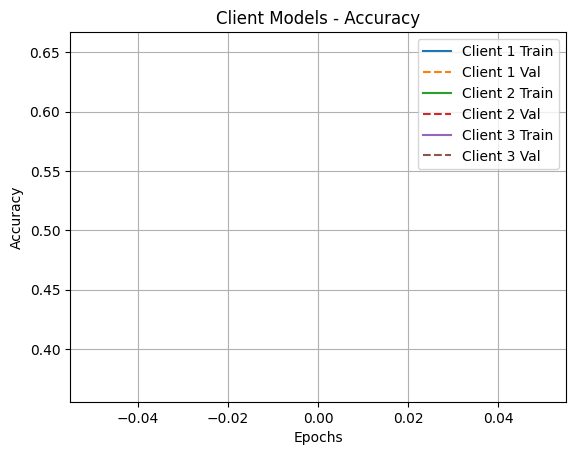

In [ ]:
for i, hist in enumerate(client_histories):
    plt.plot(hist.history['accuracy'], label=f'Client {i+1} Train')
    plt.plot(hist.history['val_accuracy'], linestyle='--', label=f'Client {i+1} Val')
plt.title('Client Models - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def fed_avg(models):
    new_weights = []
    for weights in zip(*[model.get_weights() for model in models]):
        new_weights.append(np.array(weights).mean(axis=0))
    return new_weights

In [ ]:
global_model = create_nasnet_model()

# Load client models
client_models = [load_model(f'/content/drive/MyDrive/nasnet_weights/{client}_nasnet_model.h5') for client in clients]

# Apply federated averaging
global_weights = fed_avg(client_models)
global_model.set_weights(global_weights)
global_model.save("/content/drive/MyDrive/nasnet_weights/global_nasnet_model.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'client1_nasnet_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# You can test on any client's data, here using client3 as an example
x_test, _, y_test, _ = preprocess_data('/content/Data/client3', test_size=0.99)  # Just take the test split
loss, accuracy = global_model.evaluate(x_test, y_test)
print(f"\n🟢 Global Model Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
y_pred = np.argmax(global_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot()
